In [1]:
import math
import random
from time import sleep
import pickle
import sys

import numpy as np
import pandas as pd
from matplotlib import image, pyplot, figure, patches
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
import scipy.interpolate as si

from PIL import Image, ImageDraw

In [2]:
# Initialising Path Planning Simulation Parameters

# Initialising Link Lengths of the endoscope.

tipLength = 150 # End-effector link is longer than the other analogous to the dimensions in Zsombor's thesis.
linkLength = 50 # Have simplified all the link lengths except the end-effector to be equidistant.

noOfLinks = 6 # Number of Links in the endoscope

# Distance factors for collision checking.
# Task Space Solution Generation uses a stricter factor (generationDimFactor) than Configuration Space Solution Generation (actualDimFactor)
generationDimFactor = .9
actualDimFactor = .6

In [3]:
img = Image.open('knee.png') # Reading the knee image for Simulation

In [4]:
# Transformation functions for flipping image to conventional xy axes and back to the original axes.

def convertImgAxArr2CoordAxArr(ar):
    return np.fliplr(ar.T)

def convertCoordAxArr2ImgAxArr(ar):
    return np.fliplr(ar).T

In [5]:
# Storing numpy array versions of the image in both axes

img_arr = np.array(img.convert('L'))
arr = convertImgAxArr2CoordAxArr(img_arr)

In [6]:
# Function which returns points within a square of certain length around the point of interest

def returnPointCollisionCheckingAreaPoints(collisionCheckList, numSteps, currCoord):
    for i in range(0,(numSteps+1)):
        for j in range(0,(numSteps+1)):
            collisionCheckList.append(((currCoord[0]+i),(currCoord[1]+j)))
            collisionCheckList.append(((currCoord[0]-i),(currCoord[1]+j)))
            collisionCheckList.append(((currCoord[0]+i),(currCoord[1]-j)))
            collisionCheckList.append(((currCoord[0]-i),(currCoord[1]-j)))

In [7]:
def checkLinkCollision(startCoord, endCoord, ar, dimFactor=generationDimFactor):
    
    ar = ar.copy()
    
    # Extending the line coordinates to the closest integers outside them
    
    if startCoord[0] <= endCoord[0]:
        startCoord[0] = math.floor(startCoord[0])
        endCoord[0] = math.ceil(endCoord[0])
    else:
        startCoord[0] = math.ceil(startCoord[0])
        endCoord[0] = math.floor(endCoord[0])
        
    if startCoord[1] <= endCoord[1]:
        startCoord[1] = math.floor(startCoord[1])
        endCoord[1] = math.ceil(endCoord[1])
    else:
        startCoord[1] = math.ceil(startCoord[1])
        endCoord[1] = math.floor(endCoord[1])
    
    collisionCheckList = [] # Initialising the array which should contain the list of points around a line within which collision should be checked.
    collisionTolerance = dimFactor # Collision Tolerance in mm
    stepInMM = .1 # Quantifying the value of a step in pixel in mm from geometrical approximate
    numSteps = int( collisionTolerance / stepInMM ) + 1 # Quantifying the number of pixel steps around a point for which collision should be checked.
    theta = math.atan2((endCoord[1]-startCoord[1]),(endCoord[0]-startCoord[0])) # Computing angle of the line
    tanTheta = math.tan(theta)
    
    # Identifying the leading direction of the line
    
    if -(math.pi/4) <= theta <= (math.pi/4):
        direction = 'x'
    elif (math.pi/4) <= theta <= (math.pi + (math.pi/4)):
        direction = 'y'
    elif -(math.pi + (math.pi/4)) <= theta <= -(math.pi/4):
        direction = '-y'
    else:
        direction = '-x'
    
    if '-' in direction:
        leadingStep = -1
    else:
        leadingStep = 1
    
    # Identifying the perpendicular step to be taken as we take an unit step in leading direction
    
    if 'x' in direction:
        perpendStep = tanTheta * leadingStep
        count = abs(endCoord[0]-startCoord[0])
    elif 'y' in direction:
        perpendStep = leadingStep / tanTheta
        count = abs(endCoord[1]-startCoord[1])
    
    # Collecting List of Points Around the line where collsion checking must be done
    
    for i in range(count):
        if 'x' in direction:
            nextCoord = ( ( startCoord[0] + ( i * leadingStep ) ) ,( startCoord[1] + round( i * perpendStep ) ) )
        elif 'y' in direction:
            nextCoord = ( ( startCoord[0] + round( i * perpendStep ) ) ,( startCoord[1] + ( i * leadingStep ) ) )
        returnPointCollisionCheckingAreaPoints(collisionCheckList,numSteps,nextCoord)
        
    returnPointCollisionCheckingAreaPoints(collisionCheckList,numSteps,endCoord)
    
    collisionCheckList = list(set(collisionCheckList)) # Removing duplicates from collisionCheckList
    
    # Performing Collsion Checking
    
    for coord in collisionCheckList:
        if ( coord[0] >= ar.shape[0] ) or ( coord[1] >= ar.shape[1] ):
            continue
        if ar[coord[0],coord[1]] <= 128:
            return True
        
    return False

In [8]:
# Function which Plots a Line according to our desired style processing flipped image coordinates

def plotLine(startCoord=None, endCoord=None, currCoords = None, withMarker=True, color='g'):
    if currCoords == None:
        currCoords = [startCoord, endCoord]
    if withMarker:
        pyplot.plot([c[0] for c in currCoords],[(arr.shape[1]-c[1]) for c in currCoords],linestyle='-',color=color,marker='o')
    else:
        pyplot.plot([c[0] for c in currCoords],[(arr.shape[1]-c[1]) for c in currCoords],linestyle='-',color=color)

In [9]:
class TaskSpacePlanner:
    
    # Class for task space solution generation and handling
    # Generates solution in reverse from the end configuration to the start configuration

    class Node:
        
        # Class which handles the link's end position, orientation and its parent

        def __init__(self, x, y, theta):
            
            self.x = x
            self.y = y
            self.theta = theta
            self.parent = None

    def __init__(self, start, goal, fp = 10, cp = 1.5, rho = 10, alpha = 0.06, epsilon=100, max_iter=200000, fileName=None):
        
        # Initialising the start and end coordinates for the end-effector
        
        self.start = self.Node(start[0], start[1], self.wrap_theta(start[2]))
        self.end = self.Node(goal[0], goal[1], self.wrap_theta(goal[2]))
        
        # Initialising the boundary dimension around start coordinate within which random node would be sampled
        self.init_fp = fp
        self.fpX = fp
        self.fpY = fp
        self.cp = cp # Factor of geometric increase of fp
        
        self.rho = rho # Unit step in translation
        self.alpha = alpha # Unit step in orientation
        self.epsilon = epsilon # Distance relaxation around start coordinate for convergence
        self.max_iter = max_iter # Maximum iterations of solution search
        
        self.T_goal = [self.end] # Tree of connected nodes from the end configuration
        self.trajectoryNodes = [] # List to store final main branch list of nodes from end configuration to start configuration
        self.extNodes = [] # Synthesised additional nodes for generating configuration space solution later on
        
        if not (fileName == None):
            self.load_state(fileName) # Loading solution directly from file when filename is provided
    
    # Function to store the generated solution in the object in a file
    
    def save_state(self, fileName):
        sf = pd.DataFrame(columns=["start","end","init_fp","fpX","fpY","cp","rho",
                                   "alpha","epsilon","T_goal","max_iter","trajectoryNodes","extNodes"])
        s = self.convertNodeToArray(self.start)
        e = self.convertNodeToArray(self.end)
        T_g = [self.convertNodeToArray(t) for t in self.T_goal]
        t_N = [self.convertNodeToArray(t) for t in self.trajectoryNodes]
        e_N = [self.convertNodeToArray(t) for t in self.extNodes]
        
        sf = sf.append({
                            "start":s,
                            "end":e,
                            "init_fp":self.init_fp,
                            "fpX":self.fpX,
                            "fpY":self.fpY,
                            "cp":self.cp,
                            "rho":self.rho,
                            "alpha":self.alpha,
                            "epsilon":self.epsilon,
                            "T_goal":T_g,
                            "max_iter":self.max_iter,
                            "trajectoryNodes":t_N,
                            "extNodes":e_N
                      }, ignore_index=True)
        
        sf.to_csv(fileName,index=False)
        
    # Function to read the generated solution from a file
    
    def load_state(self, fileName):
        
        sf = pd.read_csv(fileName)
        
        self.start = self.readNodeFromArray(self.local_eval(sf.start.iloc[0]))
        self.end = self.readNodeFromArray(self.local_eval(sf.end.iloc[0]))
        self.T_goal = [self.readNodeFromArray(t) for t in self.local_eval(sf.T_goal.iloc[0])]
        self.trajectoryNodes = [self.readNodeFromArray(t) for t in self.local_eval(sf.trajectoryNodes.iloc[0])]
        self.extNodes = [self.readNodeFromArray(t) for t in self.local_eval(sf.extNodes.iloc[0])]
        self.init_fp = self.local_eval(sf.init_fp.iloc[0])
        self.fpX = self.local_eval(sf.fpX.iloc[0])
        self.fpY = self.local_eval(sf.fpY.iloc[0])
        self.cp = self.local_eval(sf.cp.iloc[0])
        self.rho = self.local_eval(sf.rho.iloc[0])
        self.alpha = self.local_eval(sf.alpha.iloc[0])
        self.epsilon = self.local_eval(sf.epsilon.iloc[0])
        self.max_iter = self.local_eval(sf.max_iter.iloc[0])

    # Function for generating the task space plan
    
    def plan(self):        
        
        # Generating link's extremes from Node
        linkStartCoord = [self.end.x,self.end.y]
        linkEndX = self.end.x + ( tipLength * math.cos( self.end.theta + math.pi ) )
        linkEndY = self.end.y + ( tipLength * math.sin( self.end.theta + math.pi ) )
        linkEndCoord = [linkEndX, linkEndY]
        
        # Checking if end link under collision
        if checkLinkCollision( linkStartCoord, linkEndCoord, arr ):
            print("Start under Collision")
            return None
        
        for i in tqdm(range(self.max_iter)):
            
            rnd_node = self.get_random_node() # Generating Random Node
            
            # Identifying nearest node to random node
            nearest_ind = self.get_nearest_node_index(self.T_goal, rnd_node)
            nearest_node = self.T_goal[nearest_ind]
            
            new_node = self.steer(nearest_node, rnd_node) # Generating a new node from nearest node in the direction of random node
            
            # Generating a new node coords to verify for collision
            linkStartCoord = [new_node.x,new_node.y]
            linkEndX = new_node.x + ( tipLength * math.cos( new_node.theta + math.pi ) )
            linkEndY = new_node.y + ( tipLength * math.sin( new_node.theta + math.pi ) )
            linkEndCoord = [linkEndX, linkEndY]
            
            # Checking for collision
            if not checkLinkCollision( linkStartCoord, linkEndCoord, arr, dimFactor=actualDimFactor):
                
                self.T_goal.append(new_node) # Appending new node to tree
                self.fp = self.init_fp # Resetting random node generation window
                
                # Checking if new node is in proximity to start
                if self.calc_dist_to_start(self.T_goal[-1].x, self.T_goal[-1].y) <= self.epsilon:
                    
                    lastNode = self.T_goal[-1]
                    d, t = self.calc_distance_and_angle(self.start,lastNode)
                    
                    # Generating artifical nodes which translate the lastNode to the start node with a lower threshold of rho
                    while ( d > self.rho):
                        newX = lastNode.x + ( self.rho * math.cos( t + math.pi ) )
                        newY = lastNode.y + ( self.rho * math.sin( t + math.pi ) )
                        newNode = self.Node(newX,newY,lastNode.theta)
                        newNode.parent = lastNode
                        self.T_goal.append(newNode)
                        lastNode = self.T_goal[-1]
                        d, t = self.calc_distance_and_angle(self.start,lastNode)
                    
                    oldTheta = self.T_goal[-1].theta
                    thetaDiff = self.wrap_theta(self.start.theta - oldTheta)
                    
                    # Rotating the lastNode in steps to align with the start node's orientation
                    if not ( abs(thetaDiff) <= self.alpha ):
                        
                        thetaDiffSign = thetaDiff / abs(thetaDiff)
                    
                        while True:

                            newTheta = oldTheta + (thetaDiffSign * self.alpha)

                            if ( abs(self.wrap_theta(self.start.theta - newTheta)) < self.alpha ):
                                break

                            self.T_goal.append(self.Node(self.T_goal[-1].x,self.T_goal[-1].y,self.wrap_theta(newTheta)))
                            self.T_goal[-1].parent = self.T_goal[-2]

                            oldTheta = newTheta
                    
                    # Appending the start to the tree
                    self.start.parent = self.T_goal[-1]
                    self.T_goal.append(self.start)
                    
                    self.generate_trajectory() # Generating the main branch solution
                    
                    lastNode = self.T_goal[-1]
                    
                    for i in np.arange(self.rho, (tipLength + ( linkLength * noOfLinks ) + self.rho), self.rho):
                        
                        linkEndX = self.start.x + ( i * math.cos( self.start.theta + math.pi ) )
                        linkEndY = self.start.y + ( i * math.sin( self.start.theta + math.pi ) )
                        newNode = self.Node(linkEndX,linkEndY,self.start.theta)
                        newNode.parent = lastNode
                        self.extNodes.append(newNode)
                        lastNode = newNode
                    
                    return self.T_goal
                
            else:
                
                # Geometrically incrementing random node synthesis when generated new node is under collision upto the limit of the image shape.
                
                if self.fpX < arr.shape[0]:
                    self.fpX *= self.cp
                    self.fpX = min(self.fpX, arr.shape[0])
                    
                if self.fpY < arr.shape[1]:
                    self.fpY *= self.cp
                    self.fpY = min(self.fpY, arr.shape[1])

        return None  # if path is not found

    def steer(self, from_node, to_node):

        new_node = self.Node(from_node.x, from_node.y, self.wrap_theta(from_node.theta))
        d, theta = self.calc_distance_and_angle(new_node, to_node) # Identifying theta to move from a node to another
        
        # Taking a step of rho in the direction to to_node
        new_node.x += self.rho * math.cos(theta)
        new_node.y += self.rho * math.sin(theta)
        
        theta_diff = self.wrap_theta(math.pi + theta - new_node.theta) # Computing theta difference from from_node to to_node
        
        if not (abs(theta_diff) == 0):
            
            theta_step = self.alpha * ( theta_diff / abs(theta_diff) ) # Defining a step of magnitude alpha in theta_diff direction
            
            # Changing the new_node theta in the direction towards the to_node
            if self.alpha <= abs(theta_diff):
                new_node.theta += theta_step
            else:
                new_node.theta += theta_diff
            
        new_node.theta = self.wrap_theta(new_node.theta)

        new_node.parent = from_node

        return new_node
    
    # Function to calculate absolute distance to start node
    def calc_dist_to_start(self, x, y):
        dx = x - self.start.x
        dy = y - self.start.y
        return math.hypot(dx, dy)
    
    # Function to generate random node within a window around start node
    def get_random_node(self):
        
        # Generating random node with dynamic window size with a probability of .75 and within initial window size otherwise
        if random.random()>0.25:
            x = min( max ( 0, ( self.start.x + random.uniform(-self.fpX, self.fpX) ) ), (arr.shape[0]-1) )
            y = min( max ( 0, ( self.start.y + random.uniform(-self.fpY, self.fpY) ) ), (arr.shape[1]-1) )
        else:
            x = min( max ( 0, ( self.start.x + random.uniform(-self.init_fp, self.init_fp) ) ), (arr.shape[0]-1) )
            y = min( max ( 0, ( self.start.y + random.uniform(-self.init_fp, self.init_fp) ) ), (arr.shape[1]-1) )
        rnd = self.Node( x, y, self.wrap_theta(self.start.theta) )
        return rnd
    
    # Function to generate main branch of trajectories from start node to end node
    def generate_trajectory(self):
        
        self.trajectoryNodes = [self.T_goal[-1]]
        parentNode = self.trajectoryNodes[-1].parent
        while not (parentNode == None):
            self.trajectoryNodes.append(parentNode)
            parentNode = parentNode.parent
    
    # Function to read a node from an array
    def readNodeFromArray(self, arr):
        return self.Node(arr[0],arr[1],arr[2])
    
    # Function to evaluate python data type from string with error handling
    @staticmethod
    def local_eval(t):
        try:
            a = eval(t)
        except Exception as e:
            a = t
        return a
    
    # Function to wrap theta within - pi to + pi
    @staticmethod
    def wrap_theta(theta):
        if theta >= 0:
            theta = ( theta % ( 2 * math.pi ) )
            if theta > math.pi:
                theta -= 2 * math.pi
        elif theta < 0:
            theta = - ( abs(theta) % ( 2 * math.pi ) )
            if theta <= - math.pi:
                theta += 2 * math.pi
        return theta
    
    # Function to calculate distance and angle between coordinates of two nodes
    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta
    
    # Function to get nearest node to random node from node tree 
    @staticmethod
    def get_nearest_node_index(T_goal, rnd_node):
        dlist = [math.hypot((node.x - rnd_node.x),(node.y - rnd_node.y)) for node in T_goal]
        minind = dlist.index(min(dlist))

        return minind
    
    # Function to print details of a node
    @staticmethod
    def printNode(n):
        print(n.x,n.y,n.theta)
    
    # Function to store details of a node in an array
    @staticmethod
    def convertNodeToArray(n):
        return [n.x,n.y,n.theta]

In [10]:
# Function to check if a node is in collision

def checkNodeCollision(n,isTip=True,dimFactor=generationDimFactor):
    
    # Generating node start and end coordinates
    s = [n.x, n.y]
    if isTip:
        e = [(n.x-(tipLength*math.cos(n.theta))),(n.y-(tipLength*math.sin(n.theta)))]
    else:
        e = [(n.x-(linkLength*math.cos(n.theta))),(n.y-(linkLength*math.sin(n.theta)))]
        
    return checkLinkCollision(s, e, arr.copy(),dimFactor=dimFactor) # returning link collision results for start and end coordinates computed

In [11]:
# Function to plot node

def plotNode(n,withMarker=True,isTip=True,shouldCheck=True,dimFactor=generationDimFactor):
    
    # Generating node start and end coordinates
    s = [n.x, n.y]
    if isTip:
        e = [(n.x-(tipLength*math.cos(n.theta))),(n.y-(tipLength*math.sin(n.theta)))]
    else:
        e = [(n.x-(linkLength*math.cos(n.theta))),(n.y-(linkLength*math.sin(n.theta)))]
        
    color = 'g' # setting default color to green
    
    # Setting default color to red if asked to check and if under collision
    if shouldCheck:
        if checkLinkCollision(s, e, arr.copy(),dimFactor=dimFactor):
            color='r'

    plotLine(s,e,withMarker=withMarker,color=color) # plotting line for start and end coordinates computed

In [12]:
# Function to plot the knee environment

def plotEnvironment():
    f = pyplot.figure()
    f.set_figheight(f.get_figheight()*3)
    f.set_figwidth(f.get_figwidth()*5)
    ar = 255*np.ones([(arr.shape[0]+400),arr.shape[1]])
    ar[0:arr.shape[0],:] = arr.copy()
    pyplot.imshow(convertCoordAxArr2ImgAxArr(ar))
    del ar

In [13]:
# Setting the target

target = TaskSpacePlanner.Node(275,665,(math.pi*1.15))

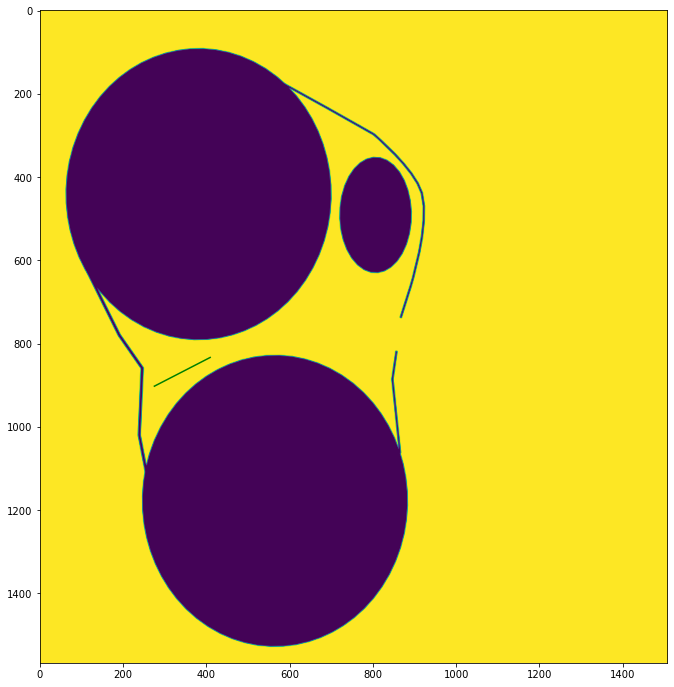

In [14]:
# Checking if the target has collision

plotEnvironment()
plotNode(target,withMarker=False,isTip=True,shouldCheck=True,dimFactor=generationDimFactor)

In [15]:
# Set Initial parameters and generate task space solution
taskSpacePlanner = TaskSpacePlanner(start=[950, 800, math.pi],goal=[target.x,target.y,target.theta], max_iter=5000)
node_list = taskSpacePlanner.plan()

if node_list is None:
    print("Cannot find path")
else:
    print("found path!!")

  0%|          | 0/5000 [00:00<?, ?it/s]

found path!!


In [16]:
fileName = f'Task_Space_Data/start_{taskSpacePlanner.start.x}_{taskSpacePlanner.start.y}_{taskSpacePlanner.start.theta}_end_{taskSpacePlanner.end.x}_{taskSpacePlanner.end.y}_{taskSpacePlanner.end.theta}.csv'

In [17]:
taskSpacePlanner.save_state(fileName) # Saving the generated solution in fileName

In [18]:
taskSpacePlanner.load_state(fileName) # Loading the generated solution from fileName

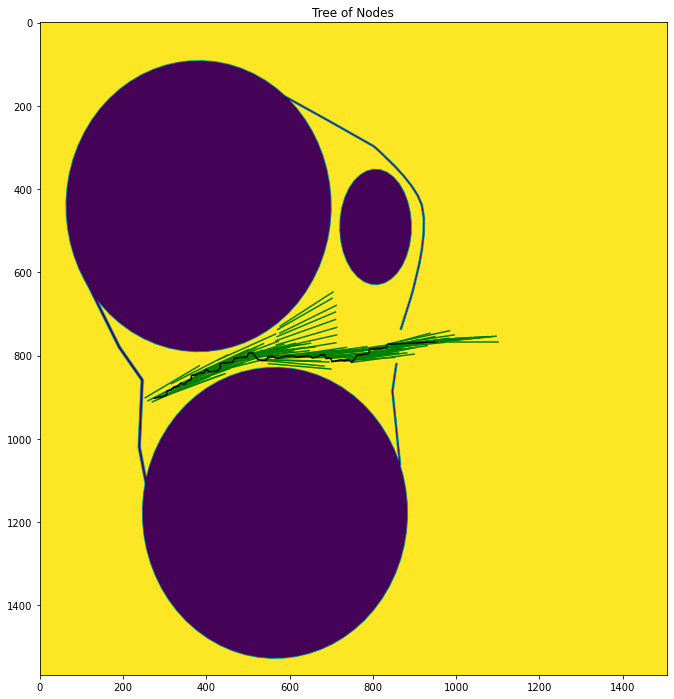

In [19]:
# Plotting the tree of nodes

plotEnvironment()
[plotNode(n,withMarker=False,dimFactor = actualDimFactor) for n in taskSpacePlanner.T_goal]
if not (len(taskSpacePlanner.trajectoryNodes) == 0):
    plotLine(currCoords=[[t.x,t.y] for t in taskSpacePlanner.trajectoryNodes],color='k',withMarker=False)
pyplot.title("Tree of Nodes")
pyplot.show()

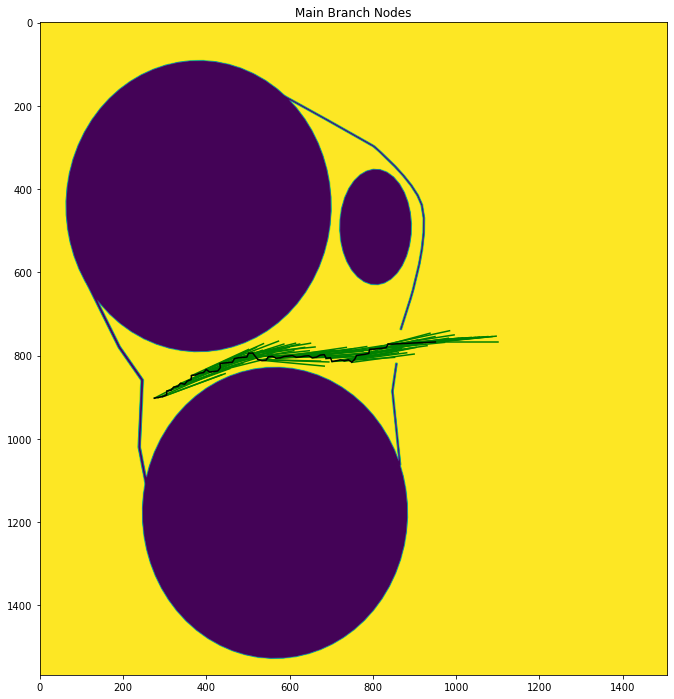

In [20]:
# Plotting the Main Branch Nodes

plotEnvironment()
[plotNode(n,withMarker=False,dimFactor=actualDimFactor) for n in taskSpacePlanner.trajectoryNodes]
if not (len(taskSpacePlanner.trajectoryNodes) == 0):
    plotLine(currCoords=[[t.x,t.y] for t in taskSpacePlanner.trajectoryNodes],color='k',withMarker=False)
pyplot.title("Main Branch Nodes")
pyplot.show()

In [21]:
# Function to smooth out trajectory obtained

def getSmooth(coords, d, n):

    def bspline(cv, n=100, degree=3):
        
        """ Calculate n samples on a bspline

            cv :      Array ov control vertices
            n  :      Number of samples to return
            degree:   Curve degree
        """
        cv = np.asarray(cv)
        count = cv.shape[0]

        # Prevent degree from exceeding count-1, otherwise splev will crash
        degree = np.clip(degree,1,count-1)

        # Calculate knot vector
        kv = np.array([0]*degree + list(range(count-degree+1)) + [count-degree]*degree,dtype='int')

        # Calculate query range
        u = np.linspace(0,(count-degree),n)

        # Calculate result
        return np.array(si.splev(u, (kv,cv.T,degree))).T
    
    cv = np.array(coords) # Converting coords to np array

    p = bspline(cv,n=n,degree=d)
    x,y = p.T
    
    coordsSmooth = [[x[i],y[i]] for i in range(len(x))]
    
    return coordsSmooth

In [22]:
# Function with params of smoothing and which returns smoothened trajectory as nodes list with static theta

def smoothTrajectory(trajectory):
    trajectoryCoordsSmooth = getSmooth([[t.x,t.y] for t in trajectory], 3, int(len(trajectory)/3))
    return [TaskSpacePlanner.Node(t[0],t[1],math.pi) for t in trajectoryCoordsSmooth]

In [23]:
# Function to obtain trajectory checklist for configuration space solution generation

def getCheckList(checkListType, var=None):
    if 'Original' in checkListType:
        checkList = [t for t in reversed(taskSpacePlanner.trajectoryNodes)]
        if 'Smooth' in checkListType:
            checkList = smoothTrajectory(checkList)
        checkList.extend(taskSpacePlanner.extNodes)
    elif 'Median' in checkListType:
        checkList = [taskSpacePlanner.Node((t.x+(var*tipLength*math.cos(t.theta+math.pi))),(t.y+(var*tipLength*math.sin(t.theta+math.pi))),0) for t in reversed(taskSpacePlanner.trajectoryNodes)]
        if 'Smooth' in checkListType:
            checkList = smoothTrajectory(checkList)
        checkList.extend([taskSpacePlanner.Node((n.x+(var*tipLength*math.cos(taskSpacePlanner.start.theta+math.pi))),(n.y+(var*tipLength*math.sin(taskSpacePlanner.start.theta+math.pi))),n.theta) for n in taskSpacePlanner.extNodes])
    return checkList

In [24]:
# Obtaining the smoothened trajectory curve

trajectoryCoordsSmooth = getSmooth([[t.x,t.y] for t in taskSpacePlanner.trajectoryNodes], 3, int(len(taskSpacePlanner.trajectoryNodes)/3))

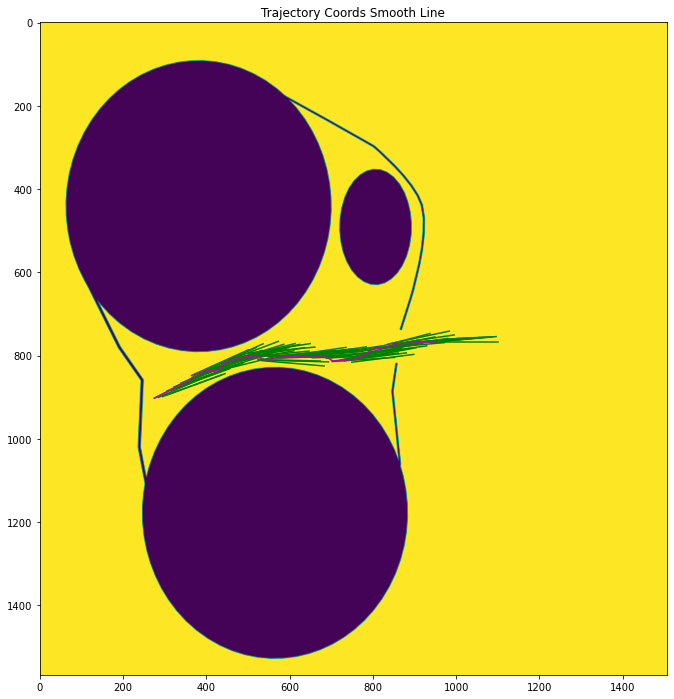

In [25]:
# Plotting the smoothened trajectory curve

plotEnvironment()
[plotNode(n,withMarker=False,shouldCheck=False) for n in taskSpacePlanner.trajectoryNodes]
if not (len(taskSpacePlanner.trajectoryNodes) == 0):
    plotLine(currCoords=trajectoryCoordsSmooth,color='m',withMarker=False)
pyplot.title("Trajectory Coords Smooth Line")
pyplot.show()

In [26]:
# Function which returns the checkpoint in checkList upto which the endoscope has already been fitted to

def getCheckPoint(x,y,checkList,checkPointIndex):
    dists = []
    for i in range(len(checkList)):
        if (i < checkPointIndex):
            dists.append(math.inf)
        else:
            n = checkList[i]
            dx = n.x - x
            dy = n.y - y
            
            dists.append(math.hypot(dx, dy))
    checkPointIndex = dists.index(min(dists)) + 1
    return checkPointIndex

In [27]:
# Function to iterate current nodelist from the last to remove the ones which face collision when translated to the
# next task space coordinate in the task space solution until something which doesnt face collision for the same is encountered.

def checkNext(nodeLists, index):
    
    # Computing theta difference between successive nodes in the last nodeList in nodeLists
    nextThetaDiffs = [taskSpacePlanner.wrap_theta(nodeLists[-1][i].theta-nodeLists[-1][i-1].theta) for i in range(1,len(nodeLists[-1]))]
    
    # Returning as no need to check when index is 0
    if index == 0:
        return nextThetaDiffs, nodeLists
    
    # Obtaining the collision check results for each of the nodes in current nodeList when translated to 
    # the next task space coordinate in the task space solution
    nl = []
    n = taskSpacePlanner.trajectoryNodes[index-1]
    n.theta = nodeLists[-1][0].theta
    currTheta = n.theta
    nl.append(n)
    l = tipLength
    collisions = []
    collisions.append(checkNodeCollision(n,isTip=(tipLength==l), dimFactor=actualDimFactor))
    for nextThetaDiff in nextThetaDiffs:
        x = n.x - l * math.cos(n.theta)
        y = n.y - l * math.sin(n.theta)
        currTheta = taskSpacePlanner.wrap_theta( currTheta + nextThetaDiff )
        n = taskSpacePlanner.Node(x,y,currTheta)
        nl.append(n)
        l = linkLength
        collisions.append(checkNodeCollision(n,isTip=(tipLength==l), dimFactor=actualDimFactor))
    
    # Handling when there is a solution
    if True in collisions:
        # If the length of nodeLists is 1 then there is no solution as the only node list is under collision when translated to the next coordinate
        if len(nodeLists) == 1:
            print("No Node List without collision in the next instant")
            raise Exception('No Solution')
        else:
            # Removing the last nodelist from nodelists and checking again
            return checkNext(nodeLists[:-1], index)
    else:
        # Returning the nodeLists when there is no collision when translated to the next coordinate
        return nextThetaDiffs, nodeLists

In [28]:
# Function for plotting a nodeList

def plotNodeList(i, currNodeList=None, shouldPlot=False, nodeList=None, dimFactor=actualDimFactor, checkList = None):
    
    global f
    pyplot.clf()
    
    # if no nodeList is provided the global NodeSuperList will be plotted
    if nodeList == None:
        nodeList = nodeSuperList
    
    if shouldPlot:
        f = pyplot.figure()
        f.set_figheight(f.get_figheight()*3)
        f.set_figwidth(f.get_figwidth()*5)
    
    ar = 255*np.ones([(arr.shape[0]+400),arr.shape[1]])
    ar[0:arr.shape[0],:] = arr.copy()
        
    pyplot.imshow(convertCoordAxArr2ImgAxArr(ar))
    
    if not (checkList == None):
        pyplot.plot([t.x for t in checkList],[(arr.shape[1]-t.y) for t in checkList],'k')
       
    if ( currNodeList == None ):
        currNodeList = nodeList[i]
    
    isTip = True
    for n in currNodeList:
        plotNode(n, isTip=isTip, dimFactor=dimFactor)
        isTip = False

In [29]:
# Function for computing the theta for aligning current link to the checkList

def computeCurrThetaStepCorrection(prevNode, prevLength, currLength, maxThetaDeviation, checkList, checkPointIndex, pastThetaDiff = None, considerMid=False, firstDiff=None):
    
    # Generating end coordinates for current link
    currX = prevNode.x - prevLength*math.cos(prevNode.theta)
    currY = prevNode.y - prevLength*math.sin(prevNode.theta)

    distToTheta = {} # Dictionary for storing distance from checklist for different orientations of current link
    
    prevTheta = prevNode.theta
    
    # Defining limits of orientation for current link with respect to previous orientation of link
    tUpperLimit = prevTheta + maxThetaDeviation
    tLowerLimit = prevTheta - maxThetaDeviation
    
    # Finding the discretisation of theta steps for which distance is to be computed
    thetaIntervals = 1000
    tStep = abs( tUpperLimit - tLowerLimit ) / thetaIntervals
    
    for t in list(np.arange(tLowerLimit,tUpperLimit,tStep)): # Iterating over thetas for finding best fit theta
        
        # Computing start point of link
        x = currX - currLength * math.cos(t)
        y = currY - currLength * math.sin(t)
        
        # Computing midpoint of link
        x2 = currX - currLength * math.cos(t) * .5
        y2 = currY - currLength * math.sin(t) * .5
        
        dists = [] # Array for storing distances
        
        for i in range(len(checkList)):
            
            if (i < checkPointIndex):
                dists.append(math.inf) # Appending infinity as the distance for all points before checkpoint index to not consider them for fitting
            else:
                n = checkList[i]
                
                # Identifying distance from current checkpoint from start point for current theta
                dx = n.x - x
                dy = n.y - y
                
                # Identifying distance from current checkpoint from mid point for current theta
                dx2 = n.x - x2
                dy2 = n.y - y2
                
                # Appending distances to distance list
                if considerMid:
                    dists.append(math.hypot(dx, dy) + (.5 * math.hypot(dx2, dy2)))
                else:
                    dists.append(math.hypot(dx, dy))
        
        # Storing minimum distance across different checkpoints for each theta
        distToTheta[min(dists)] = t
    
    minDistTheta = None
    # Loop to find any theta's without collision
    while ( minDistTheta == None ):
        if len(distToTheta)==0:
            print("No Thetas without Collision")
            raise Exception('No Solution') # Error when there are no thetas without collision
        minDist = min(list(distToTheta.keys())) # Identifying minimum distance to checklist
        minDistTheta = distToTheta[minDist] # Identifying the theta with minimum distance to checklist
        currTheta = taskSpacePlanner.wrap_theta(minDistTheta)
        # When it is the first node list we check collision only for the current theta
        if (firstDiff == None):
            if checkNodeCollision(taskSpacePlanner.Node(currX,currY,currTheta) ,isTip=False, dimFactor=actualDimFactor):
                minDistTheta = None
                distToTheta.pop(minDist) # Removing theta with collision from options list
        # If not we check for collision in the next instant as well along with current instant
        else:
            if checkNodeCollision(taskSpacePlanner.Node(currX,currY,currTheta) ,isTip=False, dimFactor=actualDimFactor) and checkNodeCollision(taskSpacePlanner.Node((currX+firstDiff[0]),(currY+firstDiff[1]),currTheta) ,isTip=False, dimFactor=actualDimFactor):
                minDistTheta = None
                distToTheta.pop(minDist) # Removing theta with collision from options list
    
    thetaDiff = currTheta-prevTheta # Finding the theta difference with previous link
    
    x = currX - currLength * math.cos(minDistTheta)
    y = currY - currLength * math.sin(minDistTheta)
    checkPointIndexNew = getCheckPoint(x,y,checkList,checkPointIndex) # Identifying the new checkpoint upto which endoscope has already beem fitted to
    
    return currX, currY, currTheta, thetaDiff, checkPointIndexNew

In [30]:
def solveConfigStepCorrection(noOfLinks=4,currThetaDiffs=[], nodeIndex=-1, checkListType='Original', considerMid=False, var=None):
    
    nextThetaDiffs = [None for _ in range(noOfLinks-1)] # Initialising the list of theta difference between links for the new instant
    # Checking if this is the first instant of configuration space solution computation
    isFirst = False
    if len(currThetaDiffs) < (noOfLinks-1):
        isFirst = True
        currThetaDiffs = nextThetaDiffs.copy()
    
    currentThetas = [] # array to store new computed thetas in sequence
    currentThetaPrevs = [] # array to store precious instant thetas in sequence
    currentNodes = [] # array to store new computed nodes in sequence

    n = taskSpacePlanner.trajectoryNodes[nodeIndex] # End-effector node from task space solution
    currentNodes.append(n) # Adding end-effector node to current nodes
    
    checkList = getCheckList(checkListType,var=var) # Fetching checklist
    
    # Obtaining new end coordinates for next node and updating checkpoint
    x = n.x - tipLength * math.cos(n.theta)
    y = n.y - tipLength * math.sin(n.theta)
    checkPointIndex = 0
    checkPointIndex = getCheckPoint(x,y,checkList,checkPointIndex)
    
    # Computing the translation difference between current instant and next instant for checking collision in the next instant
    if (nodeIndex-1) > 0:
        firstDiff = [(taskSpacePlanner.trajectoryNodes[nodeIndex-1].x-n.x),(taskSpacePlanner.trajectoryNodes[nodeIndex-1].y-n.y)]
    else:
        firstDiff = None
    
    # Computing theta's for links sequentially
    for i in range(0,noOfLinks-1):
        
        # Setting the link length
        if i == 0:
            l = tipLength
        else:
            l = linkLength
        
        # Computing and assigning the new coordinates, orientation, link to link theta difference and checkpoint
        xi, yi, thetai, nextThetaDiffs[i], checkPointIndex = computeCurrThetaStepCorrection(n,l,linkLength,(math.pi/3),checkList,checkPointIndex,currThetaDiffs[i], considerMid=considerMid, firstDiff=firstDiff)
        n = taskSpacePlanner.Node(xi, yi, thetai)
        currentNodes.append(n) # Storing the newly computed node
        currentThetas.append(n.theta) # Storing the newly computed theta
    
    # As there is no requirement of discrete transition from previous instant's solution to new solution,
    # we return the current solution directly
    if isFirst:
        return nextThetaDiffs, [currentNodes]
    
    # Computing the previous instant's thetas
    currentThetaPrevs = [taskSpacePlanner.wrap_theta(taskSpacePlanner.trajectoryNodes[nodeIndex].theta+currThetaDiffs[0])]
    for i in range(1,len(currThetaDiffs)):
        currentThetaPrevs.append(taskSpacePlanner.wrap_theta(currentThetaPrevs[-1]+currThetaDiffs[i]))
    
    # Identifying the theta transition to new solution and discretising the unit step for each link for the transition
    thetaMoves = [taskSpacePlanner.wrap_theta(currentThetas[i] - currentThetaPrevs[i]) for i in range(len(currentThetas))]
    absThetaMoves = [abs(t) for t in thetaMoves]
    maxThetaMove = max(absThetaMoves)
    noSteps = int(maxThetaMove/taskSpacePlanner.alpha)
    stepMove = [ ( t / ( noSteps ) ) for t in thetaMoves]
    
    # Obtaining the value of theta for each link in a sequence for noSteps discretisation
    # and storing it in a sequence in thetalists
    thetaLists = []
    for i in range(0,noSteps):
        thetaLists.append([])
        for j in range(len(currentThetas)):
            thetaLists[-1].append( taskSpacePlanner.wrap_theta( currentThetaPrevs[j] + ( i * stepMove[j] ) ) )        
    thetaLists.append(currentThetas)
    
    # Obtaining the node lists in sequence while checking for collision
    # If collision is encountered anywwhere inbetween the discretisation,
    # we terminate the current solution upto the instant in discretisation without collision
    nodeLists = []
    for thetaList in thetaLists:
        nodeLists.append([])
        # Obtaining end effector node
        n = taskSpacePlanner.trajectoryNodes[nodeIndex]
        x = n.x - tipLength * math.cos(n.theta)
        y = n.y - tipLength * math.sin(n.theta)
        nodeLists[-1].append(n)
        for t in thetaList:
            # Obtaining successive link nodes in sequence
            n = taskSpacePlanner.Node(x, y, t)
            x = n.x - linkLength * math.cos(n.theta)
            y = n.y - linkLength * math.sin(n.theta)
            nodeLists[-1].append(n)
            
            # Checking for collision
            if checkNodeCollision(n,isTip=False,dimFactor=actualDimFactor):
                if thetaList == thetaLists[0]: 
                    # If first instant after previous instant has collision there are no nodes left and hence no solution
                    print("No Solution in this direction")
                    # Plotting the configuration with collision for debugging
                    plotNodeList(None,currNodeList=nodeLists[-1],shouldPlot=True, dimFactor=actualDimFactor, checkList=checkList)
                    raise Exception('No Solution')
                # Returning the nodeLists upto the last instant of discretisation without collision,
                # while checking for collision in the next instant
                return checkNext(nodeLists[:-1], nodeIndex)
            
    # Returning the entire nodeLists as there is no collision in the current instant,
    # while checking for collision in the next instant
    return checkNext(nodeLists, nodeIndex)

In [31]:
nd = [] # Array storing the theta difference between links in the computed solution
nodeSuperList = [] # Array storing the computed configuration space solutions
for i in tqdm(range(len(taskSpacePlanner.trajectoryNodes))): # Iterating over the trajectory nodes in task space solution
    # Computing the configuration space solution
    nd, nl = solveConfigStepCorrection(noOfLinks=noOfLinks,currThetaDiffs=nd,nodeIndex=(len(taskSpacePlanner.trajectoryNodes)-1-i),checkListType='Original')
    nodeSuperList.extend(nl)

  0%|          | 0/81 [00:00<?, ?it/s]

<ipython-input-30-feb754d3567f>:61: RuntimeWarning: invalid value encountered in double_scalars
  stepMove = [ ( t / ( noSteps ) ) for t in thetaMoves]
<ipython-input-30-feb754d3567f>:61: RuntimeWarning: divide by zero encountered in double_scalars
  stepMove = [ ( t / ( noSteps ) ) for t in thetaMoves]


MovieWriter Pillow unavailable; using Pillow instead.


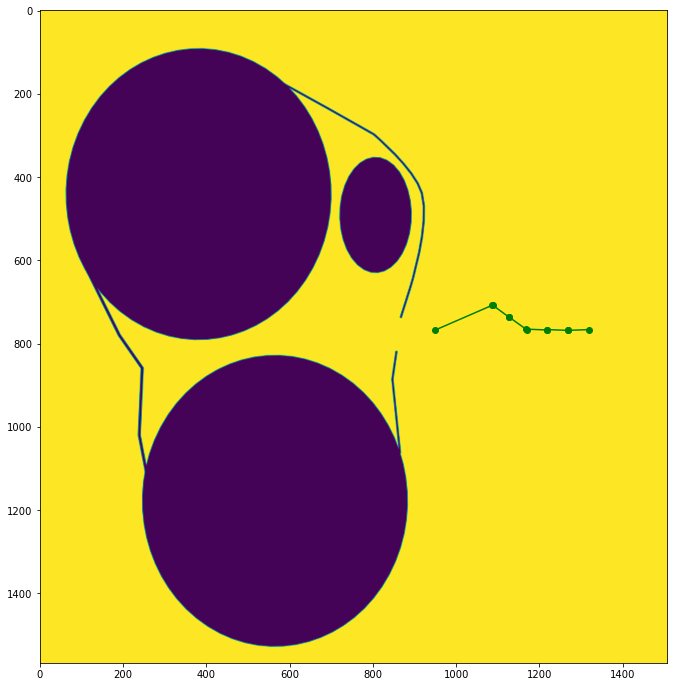

In [32]:
# Generating the gif for configuration space solution

f = pyplot.figure()
f.set_figheight(f.get_figheight()*3)
f.set_figwidth(f.get_figwidth()*5)

anim = FuncAnimation(f, plotNodeList, frames = len(nodeSuperList), interval = 40)
anim.save(f'Simulations/start_{taskSpacePlanner.start.x}_{taskSpacePlanner.start.y}_{taskSpacePlanner.start.theta}_end_{taskSpacePlanner.end.x}_{taskSpacePlanner.end.y}_{taskSpacePlanner.end.theta}_Smooth.gif',writer='Pillow')

In [33]:
from IPython.display import HTML
img_src = f'Simulations/start_{taskSpacePlanner.start.x}_{taskSpacePlanner.start.y}_{taskSpacePlanner.start.theta}_end_{taskSpacePlanner.end.x}_{taskSpacePlanner.end.y}_{taskSpacePlanner.end.theta}_Smooth.gif'
HTML(f'<img src="{img_src}">')